In [269]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [270]:
file_name = 'pre_processado_completo.csv'

df = pd.read_csv(file_name, header=0, error_bad_lines=False, warn_bad_lines=False)

In [271]:
df.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
1,lackland afb,tx,NaN,light,120.000000,1949 Lackland AFB&#44 TX. Lights racing across the sky &amp; making 90 degree turns on a dime.,29.384210,-98.581082,1949-10-10
2,chester (uk/england),NaN,gb,circle,0.333333,Green/Orange circular disc over Chester&#44 England,53.200000,-2.916667,1955-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10


In [272]:
# limita o df aos USA

df_us = df.loc[df['country'] == 'us']
df_us.head()

,city,state,country,shape,duration_m,comments,latitude,longitude,date
0,san marcos,tx,us,cylinder,45.000000,This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The...,29.883056,-97.941111,1949-10-10
3,edna,tx,us,circle,0.333333,My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took ...,28.978333,-96.645833,1956-10-10
4,kaneohe,hi,us,light,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/attack aircraft on a solo night exercise&#44 I was at 50&#44000&#39 in a ...,21.418056,-157.803611,1960-10-10
5,bristol,tn,us,sphere,5.000000,My father is now 89 my brother 52 the girl with us now 51 myself 49 and the other fellow which worked with my father...,36.595000,-82.188889,1961-10-10
7,norwalk,ct,us,disk,20.000000,A bright orange color changing to reddish color disk/saucer was observed hovering above power transmission lines.,41.117500,-73.408333,1965-10-10


In [273]:
# define um array com as latitudes e longitudes

lat_lon = np.array(df_us[['longitude', 'latitude']]).astype(float)
print(len(lat_lon))
print(lat_lon)

70290
[[ -97.9411111   29.8830556]
 [ -96.6458333   28.9783333]
 [-157.8036111   21.4180556]
 ...
 [ -97.4777778   35.6527778]
 [ -82.6958333   34.3769444]
 [ -80.1436111   26.1219444]]


In [274]:
# define uma lista com os estados, e calcula o peso de cada estado de acordo com a quantidade de avistamentos, pelo método count

states = list(df_us['state'])
pesos = [states.count(s) for s in states]

In [275]:
scaler = MinMaxScaler()

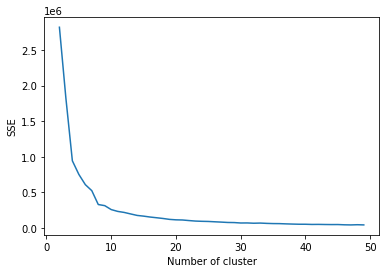

In [276]:
# aplica o elbow criteria

sse = {}
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Visto que o range para o Elbow Criteria foi grande, o número adequado de clusters está entre 8 e 22
#### A soma dos erros quadráticos não apresenta decaimento significante a partir desses valores, logo o gasto computacional para k_clusters maiores não se torna viável

### Para definir o melhor valor nesse range, foi utilizado o Coeficiente de Silhouette
#### quanto maior o coeficiente, menor a distância intracluster e maior a distância intercluster

In [278]:
# aplica o coeficiente de silhouette

for k in range(8, 22):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
    label = kmeans.labels_
    sil_coeff = metrics.silhouette_score(scaler.fit_transform(lat_lon), label, metric='euclidean')
    print("Para n_clusters={}, o coeficiente de  Silhouette {}".format(k, sil_coeff))

Para n_clusters=8, o coeficiente de  Silhouette 0.4811351012519096
Para n_clusters=9, o coeficiente de  Silhouette 0.494119152068234
Para n_clusters=10, o coeficiente de  Silhouette 0.5095988600530452
Para n_clusters=11, o coeficiente de  Silhouette 0.5150013163270807
Para n_clusters=12, o coeficiente de  Silhouette 0.5263527779673158
Para n_clusters=13, o coeficiente de  Silhouette 0.5040574833957269
Para n_clusters=14, o coeficiente de  Silhouette 0.5033175636109475
Para n_clusters=15, o coeficiente de  Silhouette 0.5056112608833657
Para n_clusters=16, o coeficiente de  Silhouette 0.4846279146642523
Para n_clusters=17, o coeficiente de  Silhouette 0.4683515649869899
Para n_clusters=18, o coeficiente de  Silhouette 0.45649472673973696
Para n_clusters=19, o coeficiente de  Silhouette 0.455467883435279
Para n_clusters=20, o coeficiente de  Silhouette 0.46818191364354145
Para n_clusters=21, o coeficiente de  Silhouette 0.4532441938788754


### De acordo com o Coeficiente de Silhouette o número adequado de clusters é em torno de 12

In [279]:
# aplica o algoritmo kmeans, utilizando os pesos e normalizando os valores

kmeans = KMeans(n_clusters=12, max_iter=2000)
kmeans.fit(scaler.fit_transform(lat_lon), sample_weight=pesos)
lat_lon_scaled = np.array(scaler.fit_transform(lat_lon))
lat_lon_scaled

array([[0.71027257, 0.22622871],
       [0.72196002, 0.20905126],
       [0.17012595, 0.06550849],
       ...,
       [0.71445329, 0.3357752 ],
       [0.84783257, 0.31155167],
       [0.87086158, 0.1548186 ]])

In [280]:
centers = kmeans.cluster_centers_
centers

array([[0.17405701, 0.05880549],
       [0.84867564, 0.43212812],
       [0.49601567, 0.38389771],
       [0.71630964, 0.24898256],
       [0.49482115, 0.55302024],
       [0.86160909, 0.32550794],
       [0.63759115, 0.39706865],
       [0.8562113 , 0.18896991],
       [0.53644424, 0.30206383],
       [0.9200891 , 0.44392307],
       [0.79338783, 0.47029818],
       [0.77223653, 0.37826261]])

In [281]:
locations = kmeans.labels_.astype(float)
print(len(locations))
locations

70290


array([ 3.,  3.,  0., ..., 11.,  5.,  7.])

Text(0, 0.5, 'Longitude')

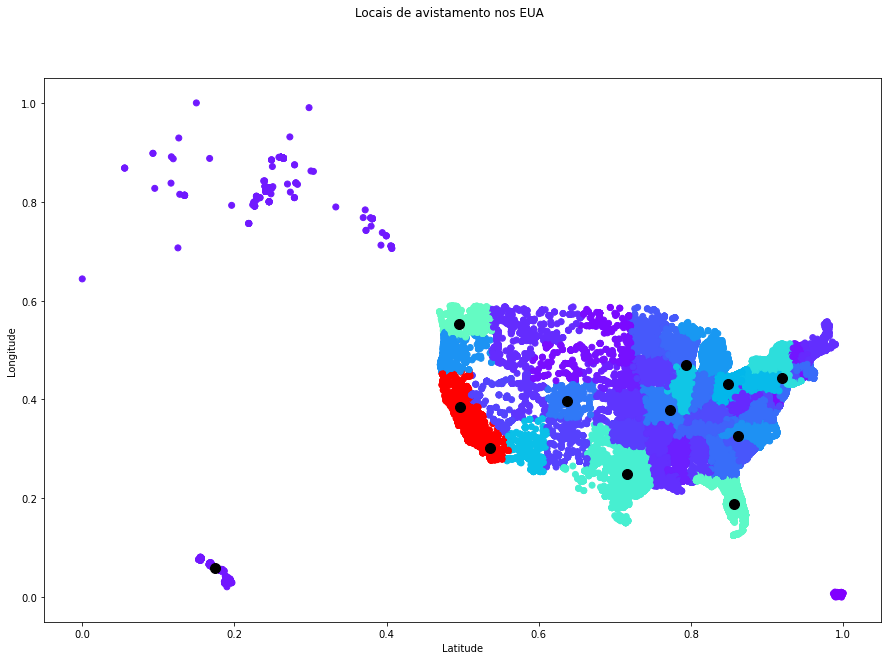

In [282]:
fig , ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(lat_lon_scaled[:, 0], lat_lon_scaled[:, 1], c=pesos, cmap='rainbow')
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
fig.suptitle('Locais de avistamento nos EUA')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

In [283]:
geolocator = Nominatim(user_agent="geoapiExercises")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [284]:
centers_notscaled = scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers_notscaled)

for index, row in df_centers.iterrows():
    df_centers.at[index, 'location'] = str(row[1]) + ', ' + str(row[0])

df_centers.drop(0, axis=1, inplace=True)
df_centers.drop(1, axis=1, inplace=True)

In [285]:
df_centers['address'] = df_centers['location'].apply(lambda loc: reverse(loc) if loc else None)

In [286]:
pd.set_option("max_colwidth", 120)
df_centers

,location,address
0,"21.065014078260866, -157.367945842029","(United States, (39.7837304, -100.4458825))"
1,"40.72760576751391, -82.60239876885596","(Sheirer Road, Troy Township, Richland County, Ohio, 44903, United States, (40.72750240724322, -82.60358538223619))"
2,"38.18735030751319, -121.68642958271518","(Newtown, Rio Vista, Solano County, California, 94571, United States, (38.185546, -121.683133))"
3,"31.081481966433195, -97.2720448593201","(6100, Little Flock Road, Bell County, Texas, 76501, United States, (31.080590175798, -97.27192952396767))"
4,"47.09489270346176, -121.81881482302522","(Pierce County, Washington, United States, (47.0022547, -122.2117983))"
5,"35.11200984424432, -81.16903164510921","(2086, State Highway 557, York County, South Carolina, 29710, United States, (35.1115151, -81.1688204))"
6,"38.88105282720767, -105.99613095584859","(Lenhardy Cutoff, Chaffee County, Colorado, United States, (38.88119135112094, -105.99692527651533))"
7,"27.920665714688855, -81.76724960561397","(Polk State College - Clear Springs Advanced Technology Center, 310, Technology Drive, Clear Springs Corporate Park,..."
8,"33.87722778114206, -117.20587807848636","(16834, Fox Trot Lane, Moreno Valley, California, 92555, United States, (33.87699019179903, -117.20672474095082))"
9,"41.348835857314505, -74.68790370916554","(Pilot - Montague, NJ 23, Duttonville, Sussex County, New Jersey, 07827, United States, (41.3495593, -74.68706575097..."


In [287]:
df_s = df_us['state'].value_counts().rename_axis('state').reset_index(name='count')
df_s.head(15)

,state,count
0,ca,9574
1,wa,4292
2,fl,4155
3,tx,3742
4,ny,3234
5,il,2698
6,az,2616
7,pa,2520
8,oh,2464
9,mi,1980
